...

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [3]:
import cartopy.feature as cf 

In [4]:
import geopandas

In [5]:
from bokeh.models import HoverTool

In [6]:
from bokeh.plotting import figure, show 
from ipywidgets import interact
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## to do
* Lost some points when I subset the spatial data so only plots over the US (not ocean etc), get those back
* Interactive plot
* Choose color-breaks manually/same colors across plots: need a way to select the range of colors used so that each temperature is alwayse the same color but the whole rainbow isn't being shown in the legend


In [120]:
#date = '2020-12'
#df = pd.read_csv('{} temperature.csv'.format(date))
data_folder = 'Data'
filename = '2020-12 temp and wind.csv'
file = os.path.join(data_folder, filename)

#df = pd.read_csv('12-2020 temp and wind.csv')
df = pd.read_csv(file)

In [121]:
gdf = geopandas.GeoDataFrame(df, 
                             geometry=geopandas.points_from_xy(df['lon'], df['lat']),
                             crs = 'epsg:4269') #crs for North America

In [122]:
gdf.columns

Index(['Unnamed: 0', 'lat', 'lon', 'average_temp', 'average_min_daily_temp',
       'min_min_daily_temp', 'average_windchill',
       'average_min_daily_windchill', 'min_min_daily_windchill', 'geometry'],
      dtype='object')

In [123]:
#from https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
#can also get school districts here!
state_file = os.path.join(data_folder, 'cb_2019_us_state_20m/cb_2019_us_state_20m.shp')
state = geopandas.read_file(state_file)

In [124]:
#https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql
state_abres = ['AK', 'PR', 'HI']
contenental_states = state[~state['STUSPS'].isin(state_abres)]
#state_test.head()

In [249]:
#plt.ion()
#plt.ioff()
#%matplotlib notebook

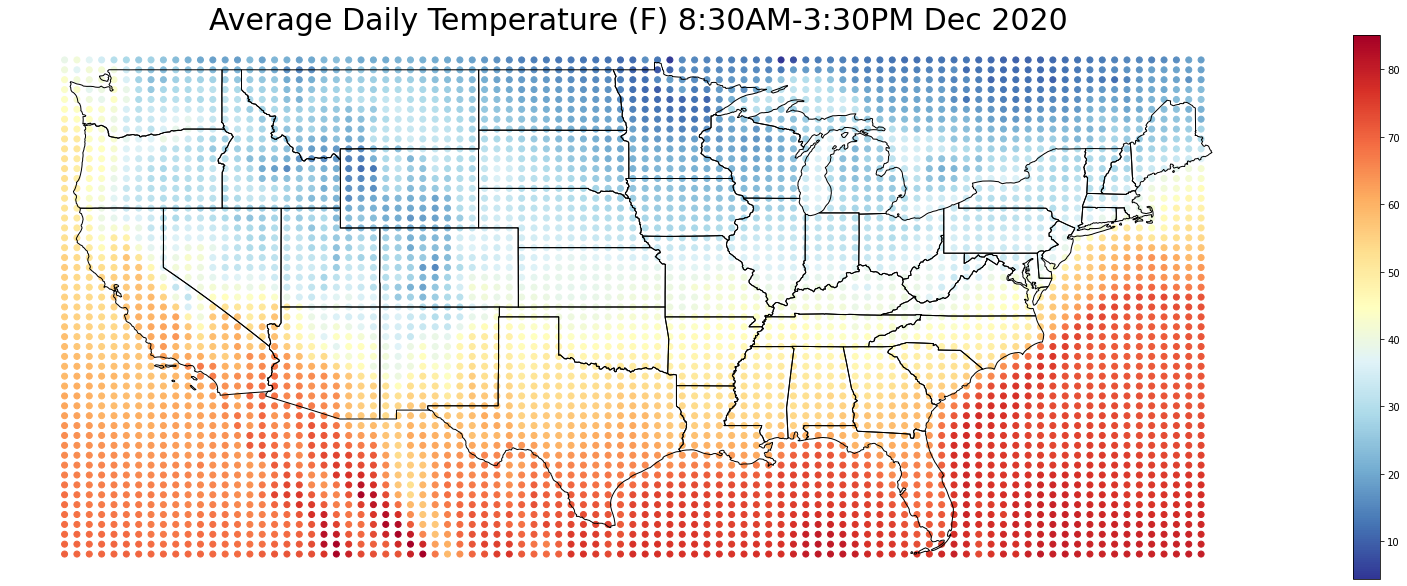

In [125]:
fig, ax = plt.subplots(figsize=(30,10))
#contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
gdf.plot(ax=ax, column = 'average_windchill', cmap = 'RdYlBu_r', legend=True)
contenental_states.plot(ax=ax, color = 'none', edgecolor='black')

ax.axis('off')
ax.set_title('Average Daily Temperature (F) 8:30AM-3:30PM Dec 2020',
            size=30);
plt.show()

In [126]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
US = world[world.name == 'United States of America'] 

In [127]:
print(US.crs)
print(gdf.crs)

{'init': 'epsg:4326'}
epsg:4269


In [128]:
US_2 = US.to_crs(epsg=4269)

In [129]:
print(US_2.crs)
print(gdf.crs)

{'init': 'epsg:4269', 'no_defs': True}
epsg:4269


In [130]:
# https://stackoverflow.com/questions/63369715/filter-a-geopandas-dataframe-within-a-polygon-and-remove-from-the-dataframe-the
gdf['withinQ'] = "" #add empty column

withinQlist = []
for i in range(len(gdf)):
    withinQ = gdf['geometry'][i].within(US['geometry'].values[0])
    #print( withinQ )
    withinQlist.append(withinQ)

# update values in the that column, values: True/False
gdf['withinQ'] = withinQlist

In [131]:
constricted_gdf= gdf[df.withinQ==True]

In [138]:
from matplotlib.colors import ListedColormap, BoundaryNorm

In [328]:
colors = {-10.0: '#4d004b', 0.0:'#3f007d',10.0:'#08519c', 
          20.0:'#4292c6',30.0:'#9ecae1',
          40.0:'#99d8c9', 50.0:'#ffffcc', 60.0:'#fed976', 
          70.0:'#feb24c', 80.0:'#fd8d3c', 90.0:'#e31a1c'}

In [329]:
def plot_map(constricted_gdf, contenental_states, column, colors):
    fig, ax = plt.subplots(figsize=(30,8))
    #contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
    
    testcol = []
    testnorm = []

    for i in constricted_gdf[column]:
        if round(i,0) in colors.keys():
            testnorm.append(round(i,0))

    norms = sorted(list(set(testnorm)))  


    
    #deal with boundries (e.g min of 9 F needs to go to 0, max of 61F needs to go to 70)
    if constricted_gdf[column].min()<norms[0]:
        norms = [round(constricted_gdf[column].min()-5, -1)] + norms
    
    if constricted_gdf[column].max()>norms[-1]:
        norms.append(round(constricted_gdf[column].max()+4, -1))
   
    #get colors from the colors dict
    for i in norms:
        testcol.append(colors[i])   
    
    cmap = ListedColormap(testcol)
    norm = BoundaryNorm(norms, cmap.N)

    constricted_gdf.plot(ax=ax, column = column, 
                     cmap = cmap, norm=norm,
                     markersize = 110, alpha = 0.8,
                     legend=True)
    contenental_states.plot(ax=ax, color = 'none', edgecolor='black')

    #cmap = 'RdYlBu_r'

    ax.axis('off')
    ax.set_title('Average Daily Temperature (F) 8:30AM-3:30PM Dec 2020',
                size=25);
    
    #check that it worked
    print(norms)
    print(testcol)
    print(constricted_gdf[column].min())
    print(constricted_gdf[column].max())
    plt.show()

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0]
['#3f007d', '#08519c', '#4292c6', '#9ecae1', '#99d8c9', '#ffffcc', '#fed976', '#feb24c', '#fd8d3c']
8.57761223845783
74.71270363435184


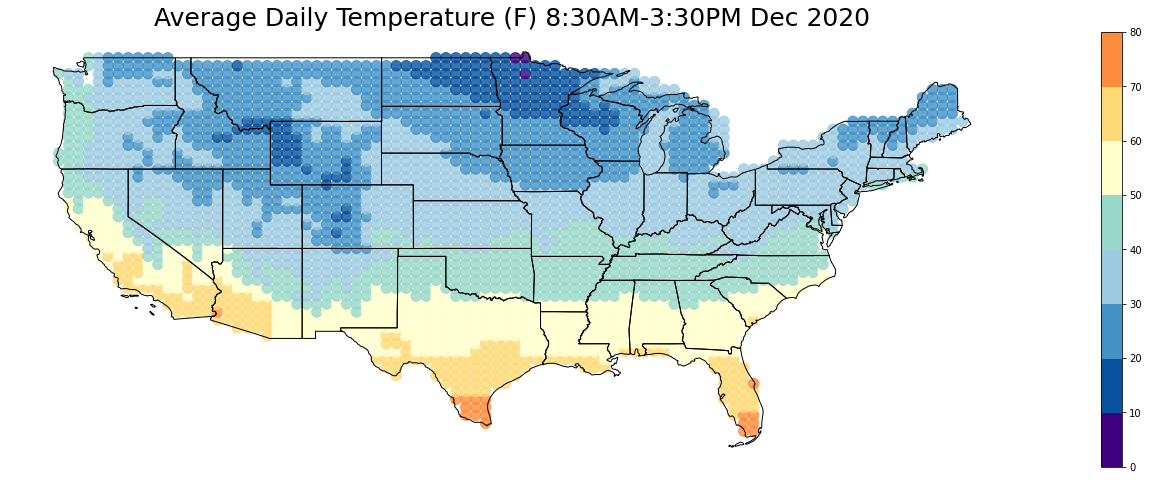

In [330]:
plot_map(constricted_gdf, contenental_states, 'average_windchill', colors)

In [331]:
tl = [1,2,3]
[0] + tl

[0, 1, 2, 3]

[-10.0, -0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 70.0]
['#4d004b', '#3f007d', '#08519c', '#4292c6', '#9ecae1', '#99d8c9', '#ffffcc', '#fed976', '#feb24c', '#feb24c']
-5.647785742600354
70.42641703944055


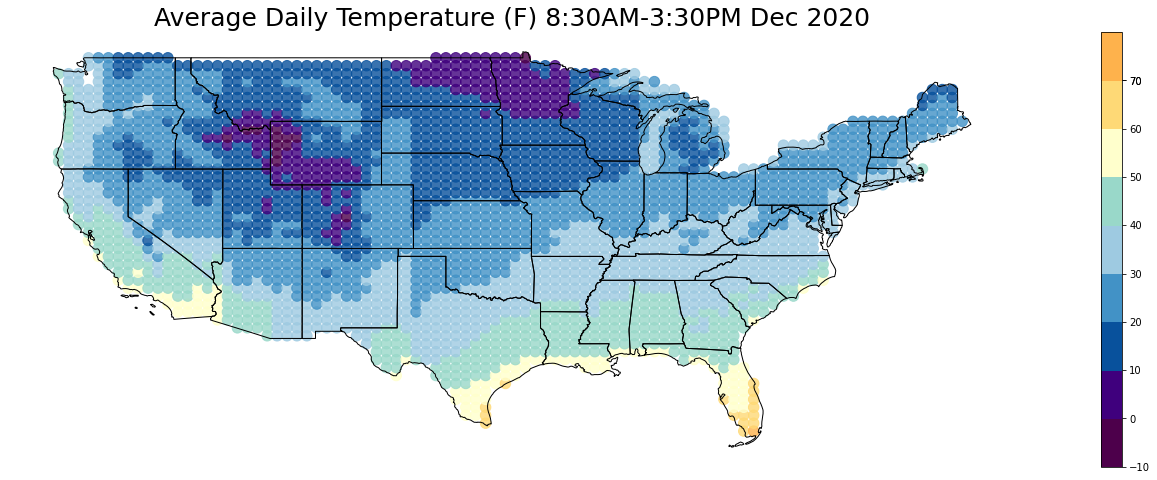

In [332]:
plot_map(constricted_gdf, contenental_states, 'average_min_daily_windchill', colors)

In [287]:
round(constricted_gdf['average_min_daily_windchill'].min(),-1)

-10.0

In [259]:
#practice pulling only set colors
test1 = [10.2,20.0,30.4]
test2 = [30,40,90]
test3 = [2,20,30, 20,20]


colors = {-10.0: '#3f007d', 0.0:'#54278f',10.0:'#08519c', 
          20.0:'#4292c6',30.0:'#9ecae1',
          40.0:'#99d8c9', 50.0:'#ffffcc', 60.0:'#fed976', 
          70.0:'#feb24c', 80.0:'#fc4e2a', 90.0:'#e31a1c'}


testcol = []
testnorm = []

for i in test3:
    if round(i,0) in colors.keys():
        testcol.append(colors[round(i,0)])
        testnorm.append(round(i,0))

list(set(testcol))

['#08519c', '#4292c6']

In [207]:
round(11,0) in colors.keys()

print(round(constricted_gdf['average_windchill'].min(),-1))
print(round(constricted_gdf['average_windchill'].max(),1))
print(round(76,-1))
print(round(75.0,-1))

10.0
74.7
80
80.0


## School District
Just have unified dists and elemntary (missing secondary, but it's too many lines already)

In [143]:
elementary_file = os.path.join(data_folder, 'cb_2019_us_elsd_500k/cb_2019_us_elsd_500k.shp')
elementary_dist = geopandas.read_file(elementary_file)

In [146]:
unified_file = os.path.join(data_folder, 'cb_2019_us_unsd_500k/cb_2019_us_unsd_500k.shp')
unified_dist = geopandas.read_file(unified_file)

In [150]:
unified_dist['STATEFP'].head()

0    42
1    27
2    29
3    01
4    17
Name: STATEFP, dtype: object

In [151]:
state_fips = ['02', '15', '60', '66', '69', '72', '78']
contenental_unified_dist = unified_dist[~unified_dist['STATEFP'].isin(state_fips)]
#state_test.head()

In [141]:
gdf.crs

'epsg:4269'

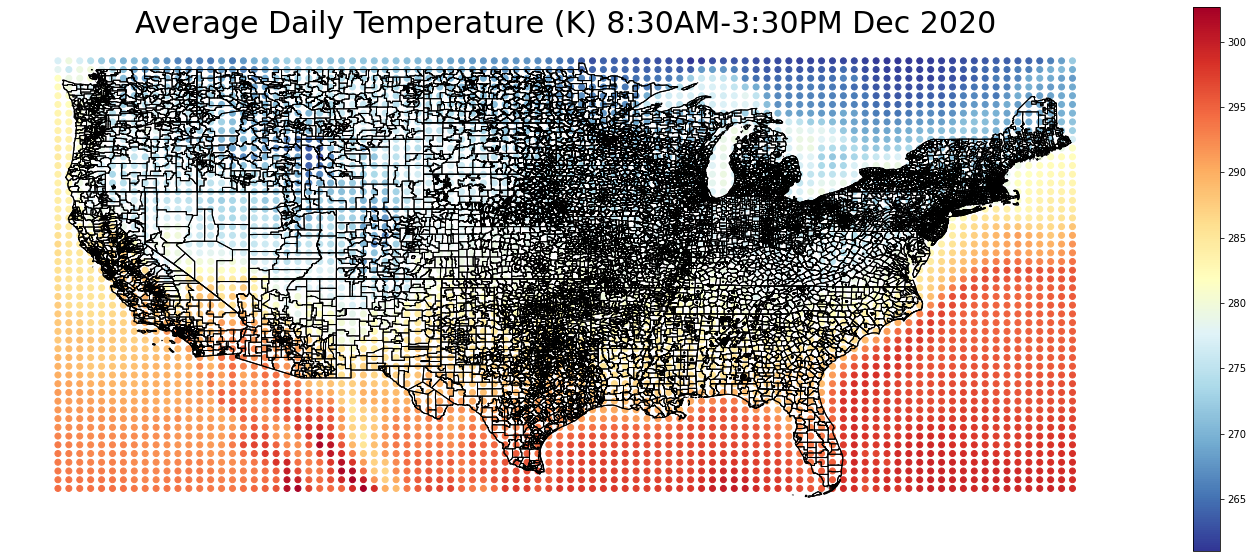

In [153]:
fig, ax = plt.subplots(figsize=(25,10))
#contenental_states.plot(ax=ax, color = 'none', edgecolor='black')
gdf.plot(ax=ax, column = 'average_temp', cmap = 'RdYlBu_r', legend=True)
elementary_dist.plot(ax=ax, color = 'none', edgecolor='black')
contenental_unified_dist.plot(ax=ax, color = 'none', edgecolor='black')
contenental_states.plot(ax=ax, color = 'none', edgecolor='black')



ax.axis('off')
ax.set_title('Average Daily Temperature (K) 8:30AM-3:30PM Dec 2020',
            size=30);

## Try interactive

In [243]:
#from matplotlib import cm,colors
plot = figure(tooltips=[("value", "@gdf['average_temp']"), ("y", "$y")])
#gdf.plot(ax = plot, column = 'average_temp', cmap = 'RdYlBu_r', legend=True)
plot.circle(gdf['lon'], gdf['lat'], color = gdf['average_temp'])#, palette = cm.get_cmap("jet"))#, cmap = 'RdYlBu_r')#, legend=True)
show(plot)

## Origional -contourform

In [37]:
def contouform_map(df, values, title, date):
    '''values: the column name to use for temperature values
        title: what is in that column (for the plot title)
        date: month and year of the data (for the plot title)
    '''
    #https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    df_pivoted = df.pivot(index = 'lat', columns = 'lon', values = values)
    df_pivoted.columns
    X=df_pivoted.columns#.levels[1].values
    Y=df_pivoted.index.values
    Z=df_pivoted.values
    lon,lat = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(12,10))
    ax = plt.axes(projection=ccrs.Mercator())

    extent = (X.min(), X.max(), Y.min(), Y.max()-3.5) #the Y-max is greater than the data?! (does this mean there's a problem?)
    ax.set_extent(extent)
    #ax.set_extent([-400,-180,25,377])
    ax.coastlines(resolution="110m",linewidth=1)
    ax.add_feature(cf.STATES)
    # https://coderzcolumn.com/tutorials/data-science/cartopy-basic-maps-scatter-map-bubble-map-and-connection-map 

    plt.contourf(lon, lat, Z, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
    plt.title('{} (F) 8:30AM-3:30PM {}'.format(title, date), size=15)
    cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.5)
    cb.set_label('F',size=14,rotation=0,labelpad=15)
    cb.ax.tick_params(labelsize=10)
    #ax.spines['top'].set_visible(False) #doesn't work
    #plt.show()
    plt.savefig('{} (F) 8:30AM-3:30PM {}'.format(title, date))
    


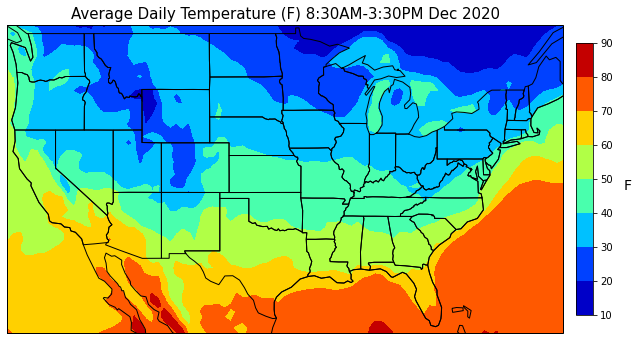

In [38]:
contouform_map(df, 'average_temp', 'Average Daily Temperature', 'Dec 2020')

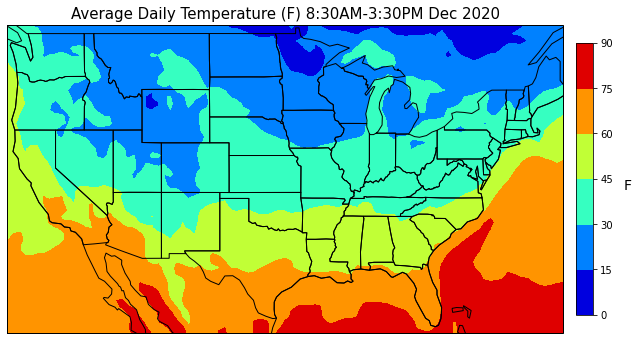

In [39]:
contouform_map(df, 'average_windchill', 'Average Daily Temperature', 'Dec 2020')

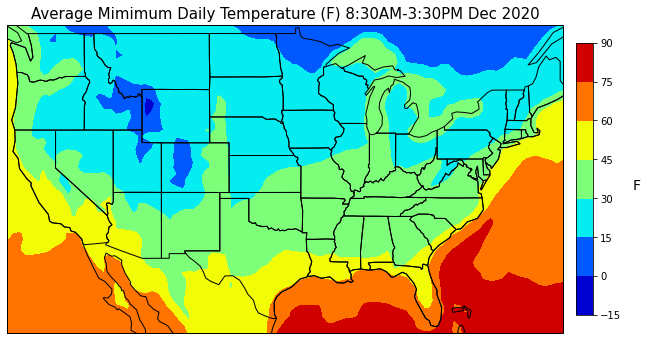

In [41]:
contouform_map(df, 'average_min_daily_temp', 'Average Mimimum Daily Temperature', 'Dec 2020')

In [40]:
df.columns

Index(['Unnamed: 0', 'lat', 'lon', 'average_temp', 'average_min_daily_temp',
       'min_min_daily_temp', 'average_windchill',
       'average_min_daily_windchill', 'min_min_daily_windchill', 'geometry'],
      dtype='object')